In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import PROJECT.util as f
from matplotlib.pyplot import cm

In [9]:
# Pour des vecteurs u* et v*,
# les overlaps obtenus sont soit les deux positifs ou les deux négatifs, on a:
# overlap(u*)= -x et overlap(v*)= -y ou overlap(u*)= x et overlap(v*)= y.
# on prend donc le min(u-x, u+x):

# si u est positif et x est positif:
# min(u-x, u+x) -> u-x est bon

# si u est positif et x est négatif:
# min(u-(-x), u+(-x)) -> u+(-x) =u-x est bon

# si u est négatif et x est positif:
# min(-u-x, -u+x) -> -u+x =x-u est bon

# si u est négatif et x est négatif:
# min(-u-(-x), -u+(-x)) -> -u-(-x) =x-u est bon

def mse(x,y):
    a=torch.pow((x-y),2).mean(0)
    b=torch.pow((x+y),2).mean(0)
    return torch.min(a,b)

In [14]:
def main_gradient_2_sans_proj_normalisation(iteration, u_p, v_p, Y, u_, v_, N, M, lambda_, beta_u, beta_v, lambda_1, lambda_2, dt):

    res = []
    res_mse= []
    
    mod = iteration*0.1
    
    stabilisation_check=np.empty((0,2))

    for i in range(iteration):

        # Computation
        sqrt_dt = torch.sqrt(dt)

        u_1 = (1/lambda_1) * f.gradient_u_2(N, M, u_p,v_p,Y,lambda_) * dt
        u_2 = torch.sqrt(2/(lambda_1*beta_u)) * torch.empty(N).normal_(mean=0,std=sqrt_dt)
        u_3 = ((N-1)/(N*lambda_1*beta_u))*u_p*dt
        u_n = u_p - u_1 + u_2 - u_3

        v_1 = 1/lambda_2 * f.gradient_v_2(N,M,u_p,v_p,Y,lambda_) * dt
        v_2 = torch.sqrt(2/(lambda_2*beta_v)) * torch.empty(M).normal_(mean=0,std=sqrt_dt)
        v_3 = ((M-1)/(M*lambda_2*beta_v))*v_p*dt
        v_n = v_p - v_1 + v_2 - v_3

        # Normalisation
        u_n = u_n / torch.linalg.norm(u_n)
        v_n = v_n / torch.linalg.norm(v_n)
        u_n = u_n * torch.sqrt(N)
        v_n = v_n * torch.sqrt(M)

        # Re-asign for the loop
        u_p = u_n
        v_p = v_n
    
        res_u = torch.abs(f.overlap(u_,u_n,N))
        res_v = torch.abs(f.overlap(v_,v_n,M))
        res.append((res_u,res_v))
        
        res_mse.append((mse(u_,u_n), mse(v_,v_n)))
        
        if len(stabilisation_check)==0:
            #print("INIT")
            stabilisation_check=np.append(stabilisation_check, [[res_u,res_v]], axis=0)
        elif len(stabilisation_check)==200:
            #print("FINISH")
            print(f"overlap(u, v): ({res_u}; {res_v})")
            return np.array(res), np.array(res_mse)
        elif (np.abs(stabilisation_check-[res_u,res_v])<0.0001).all():
            #print("ADD")
            stabilisation_check=np.append(stabilisation_check, [[res_u,res_v]], axis=0)
        else:
            #print("RESET")
            stabilisation_check=np.empty((0,2))
        
        if i%mod==0:
            print(f"progress {100*i/iteration:.2f}%", end="\r")
        if i==iteration-1:
            print(f"overlap(u, v): ({res_u}; {res_v})")

    return np.array(res), np.array(res_mse)

In [15]:
def one_run(lambda_=2, N=500, M=500, beta_u=float("inf"), beta_v=float("inf"), lambda_1=1,
        lambda_2=1, dt=1/100, iteration=10):
      #Size of the matrix Y
    N = torch.tensor(N)
    M = torch.tensor(M)

    # lambda
    lambda_ = torch.tensor(lambda_)

    #temperatures
    beta_u = torch.tensor(beta_u)
    beta_v = torch.tensor(beta_v)

    #learning rates
    lambda_1 = torch.tensor(lambda_1)
    lambda_2 = torch.tensor(lambda_2)

    # Pas de temps
    dt = torch.tensor(dt)

    u_ = f.generate_vector(N)
    v_ = f.generate_vector(M)

    Y = f.generate_Y(N, M, u_,v_, lambda_)
    #print(Y)

    # Conditions initiales
    u_p = f.generate_vector(N)
    v_p = f.generate_vector(M)

    # Perform the gradient descent
    (res, res_mse) = main_gradient_2_sans_proj_normalisation(iteration, u_p, v_p, Y, u_, v_, N, M, lambda_, beta_u, beta_v, lambda_1, lambda_2, dt)
    
    return res, res_mse


In [16]:
# MAIN METHOD:

def main(size_of_one_sample, list_value_):
    
    all_overlap_iterations=[]
    all_final_overlaps=[]
    
    all_mse_iterations=[]
    all_final_mse=[]
    
    for value_to_test in list_value_:
        
        one_run_overlap_iterations=[]
        one_run_mse_iterations=[]
        
        # Calculation
        for _ in range(size_of_one_sample):
            (current_uv_overlap,current_uv_mse)=one_run(lambda_=value_to_test)
            # Store the overlap at the end of each iterations:
            one_run_overlap_iterations.append(current_uv_overlap)
            # Store the mse at the end of each iterations:
            one_run_mse_iterations.append(current_uv_mse)
        
        # Store the overlap/mse at the final iteration:
        one_run_final_overlap = np.array([x[-1] for x in one_run_overlap_iterations])
        one_run_final_mse = np.array([x[-1] for x in one_run_mse_iterations])
        
        # Add the results of this specific run to the global array:
        # overlap at all iterations:
        all_overlap_iterations.append(one_run_overlap_iterations)
        # overlap at the final iteration:
        all_final_overlaps.append(one_run_final_overlap)
        # mse at all iterations:
        all_mse_iterations.append(one_run_mse_iterations)
        # mse at the final iteration:
        all_final_mse.append(one_run_final_mse)
        
    return np.array(all_overlap_iterations), np.array(all_final_overlaps), np.array(all_mse_iterations), np.array(all_final_mse)

In [19]:
# MAIN CELL: DO THE COMPUTATION

#list_value_ = np.logspace(-1,1)
#list_value_ = np.arange(0.1, 3, 0.1)
#list_value_ = np.array([0.5,1,2,10])
list_value_ = np.array([1,2])

size_of_one_sample=10

(overlap_at_each_iterations, overlap_at_final_iteration,
 mse_at_each_iterations, mse_at_final_iteration) = main(size_of_one_sample, list_value_)

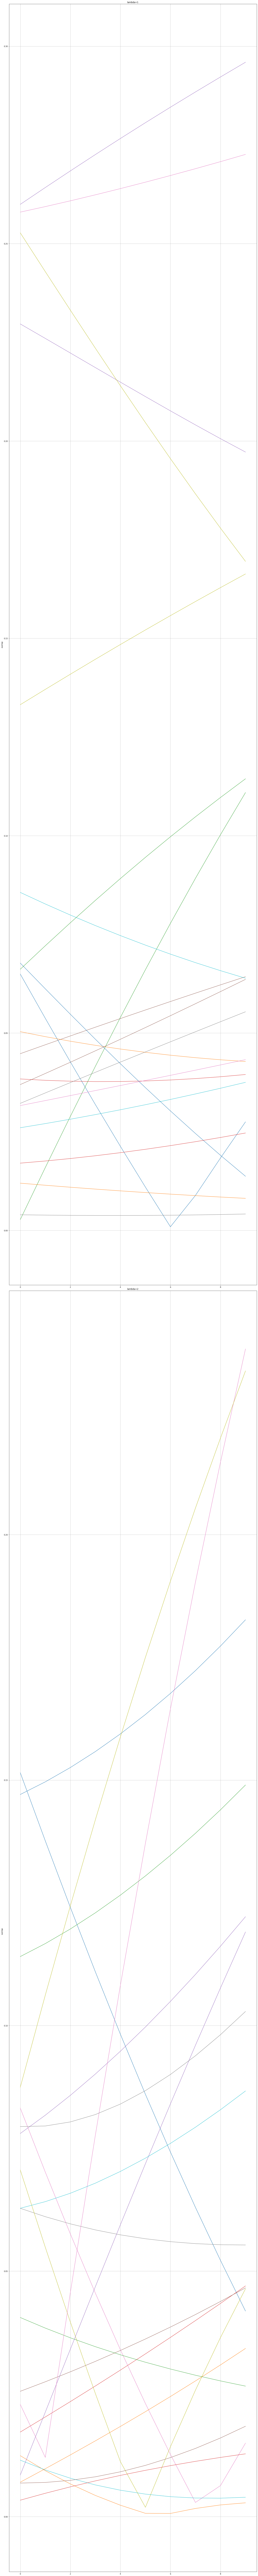

In [20]:
# PRINT THE OVERLAP IN FUNCTION OF THE STEP
name_val="lambda"

fig, axs = plt.subplots(len(list_value_), figsize=(20,200), facecolor='white')
fig.tight_layout()

for i in range(len(list_value_)):
    axs[i].grid()
    axs[i].set_ylabel("overlap")
    axs[i].set_title(f"{name_val}={list_value_[i]}")
    for run_in_on_sample in range(size_of_one_sample):
        axs[i].plot(overlap_at_each_iterations[i][run_in_on_sample])

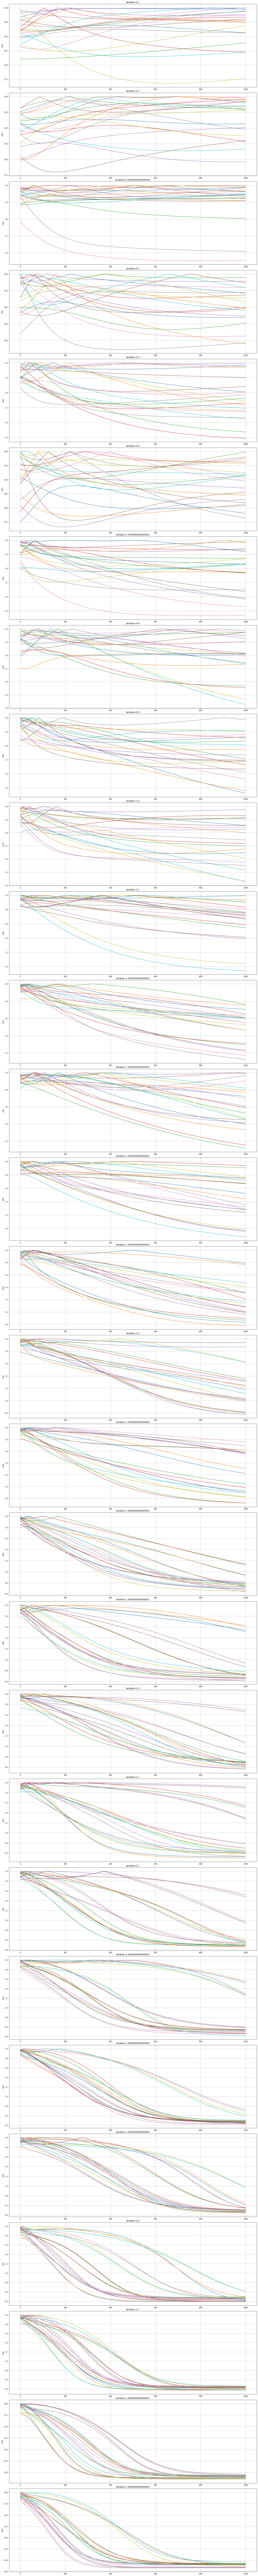

In [29]:
# PRINT THE MSE IN FUNCTION OF THE STEP
name_val="lambda"

fig, axs = plt.subplots(len(list_value_), figsize=(20,200), facecolor='white')
fig.tight_layout()

for i in range(len(list_value_)):
    axs[i].grid()
    axs[i].set_ylabel("mse")
    axs[i].set_title(f"{name_val}={list_value_[i]}")
    for run_in_on_sample in range(size_of_one_sample):
        axs[i].plot(mse_at_each_iterations[i][run_in_on_sample])

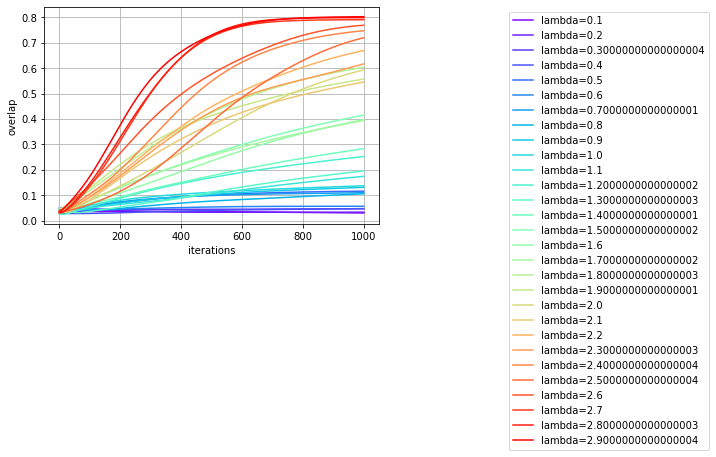

In [24]:
# PRINT THE OVERLAP IN FUNCTION OF THE STEP

overlap_at_each_iterations_per_sample=overlap_at_each_iterations.mean(axis=1).mean(axis=2)

plt.figure(facecolor='white')
plt.grid()
plt.ylabel("overlap")
plt.xlabel("iterations")
color=iter(cm.rainbow(np.linspace(0,1,len(list_value_))))

for i in range(len(list_value_)):
    c=next(color)
    plt.plot(overlap_at_each_iterations_per_sample[i],
             label=f"{name_val}={list_value_[i]}", color=c)
plt.legend(loc='upper right', bbox_to_anchor=(2, 1))

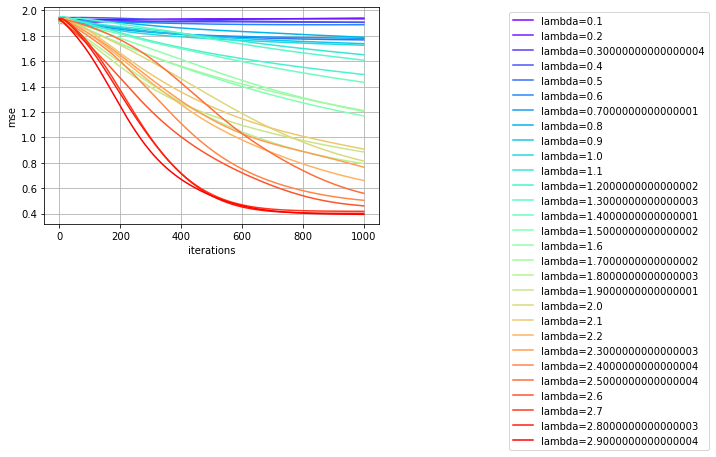

In [25]:
# PRINT THE MSE IN FUNCTION OF THE STEP
mse_at_each_iterations_per_sample=mse_at_each_iterations.mean(axis=1).mean(axis=2)

plt.figure(facecolor='white')
plt.grid()
plt.ylabel("mse")
plt.xlabel("iterations")
color=iter(cm.rainbow(np.linspace(0,1,len(list_value_))))

for i in range(len(list_value_)):
    c=next(color)
    plt.plot(mse_at_each_iterations_per_sample[i], 
             label=f"{name_val}={list_value_[i]}",color=c)
plt.legend(loc='upper right', bbox_to_anchor=(2, 1))

<ipython-input-26-3479ba38c754>:10: RuntimeWarning: invalid value encountered in double_scalars
  p = [(1-(1/list_value_[i]))**0.5 for i in range(len(list_value_))]


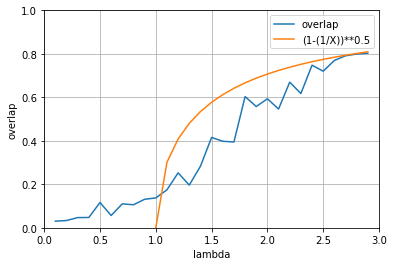

In [26]:
overlap_mean_u_v = overlap_at_final_iteration.mean(axis=1).mean(axis=1)

plt.figure(facecolor='white')
plt.grid()
plt.ylim(0,1)
plt.xlim(0,3)
plt.ylabel("overlap")
plt.xlabel(name_val)

p = [(1-(1/list_value_[i]))**0.5 for i in range(len(list_value_))]
#p = [(1-(1/2))**0.5 for i in range(len(list_value_))]

plt.plot(list_value_, overlap_mean_u_v, marker="", 
         linestyle ="solid", label="overlap")
plt.plot(list_value_, p, linestyle="solid",
         marker="", label="(1-(1/X))**0.5")
plt.legend()

In [31]:
print(f"lambda= {list_value_[i]} -> {(1-(1/list_value_[i]))**0.5}, overlap: {overlap_mean_u_v[i]}")

lambda= 2.9000000000000004 -> 0.8094272134003795, overlap: 0.8031041622161865


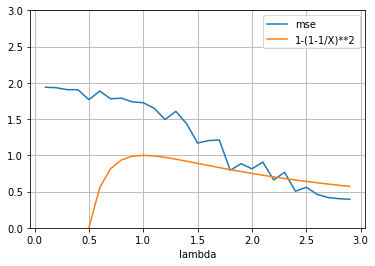

In [32]:
mse_mean_u_v = mse_at_final_iteration.mean(axis=1).mean(axis=1)

plt.figure(facecolor='white')
plt.grid()
plt.ylim(0,3)
#plt.xlim(0,3)
plt.xlabel(name_val)

plt.plot(list_value_, mse_mean_u_v, marker="", linestyle ="solid", label="mse")
plt.plot(list_value_, 1-(1-(1/list_value_))**2, linestyle="solid",marker="", label="1-(1-1/X)**2")
plt.legend()

In [34]:
print(f"lambda= {list_value_[i]} -> {1-(1-(1/list_value_[i]))**2}, mse: {mse_mean_u_v[i]}")

lambda= 2.9000000000000004 -> 0.5707491082045184, mse: 0.39379173517227173
